In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine, euclidean
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import f_oneway, tukey_hsd, kruskal, shapiro
import seaborn as sns
import datetime
import scipy
import sklearn

In [2]:
print(f'seaborn version {sns.__version__}')
print(f'numpy version {np.__version__}')
print(f'scipy version {scipy.__version__}')
print(f'pandas version {pd.__version__}')
print(f'scikit_posthocs version {sp.__version__}')

seaborn version 0.13.2
numpy version 1.26.4
scipy version 1.11.4
pandas version 2.1.4
scikit_posthocs version 0.9.0


In [4]:
emb_df = pd.read_csv('embedding.csv')
all_df = pd.read_csv('all_df.csv')

We assume that apps with similar desciptions, would have a similar asking price in the auctions (sentPrice column).

Use cosine similarity (<=>) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

-------------------------Start Analize-------------------------------

To analyze the hypothesis, we will calculate the cosine distance. It might happen that the cosine distance between several applications will be indistinguishably small.

In this case, I think it would be necessary to use an unsupervised learning solution to group similar applications into clusters and compare the prices set within these clusters to the prices of applications in other clusters. 

For this, I will use the K-means algorithm. Since optimization seeks to minimize the Euclidean distance and embeddings have a rather large dimension, this leads to the curse of dimensionality, when all points end up at the boundary of our space.

The large size of embeddings makes the algorithm work slower, so to speed up, I will reduce the dimension of the space using PCA method, choosing the number of principal components such that 90 percent of the variance is retained.


In [5]:
# convert the string to an array of numbers.
emb_df['embedding'] = emb_df['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split(',')]))

In [6]:
X = emb_df['embedding']
X = np.stack(X.to_numpy())
expl_var = np.array([])
for i in range(1, 15):
    pca = PCA(n_components=i)
    pca.fit(X)
    expl_var = np.append(expl_var, [pca.explained_variance_ratio_.sum()])

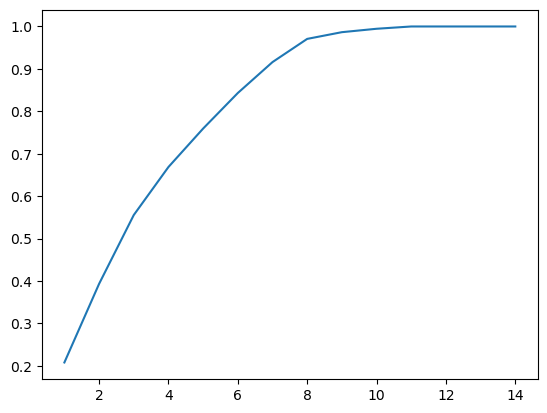

In [7]:
plt.plot(np.arange(1, 15), expl_var);

As can be seen, 8 principal components explain 95 percent of the variance.

In [8]:
pca = PCA(n_components=8)
pca.fit(X)
X_pca = pca.transform(X)

Let's divide our applications into clusters in this lower-dimension space.

100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


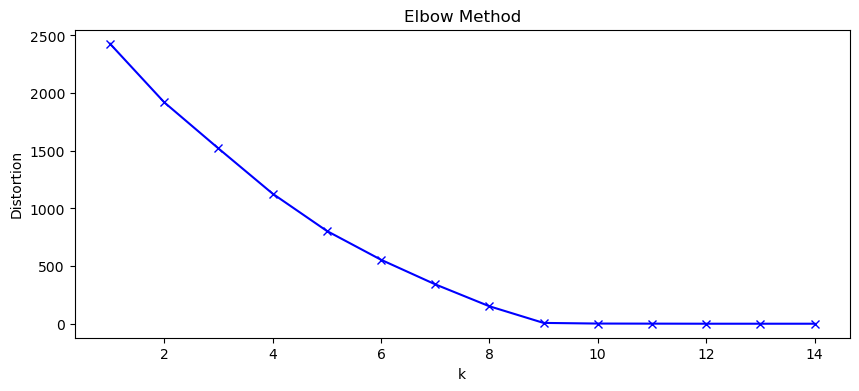

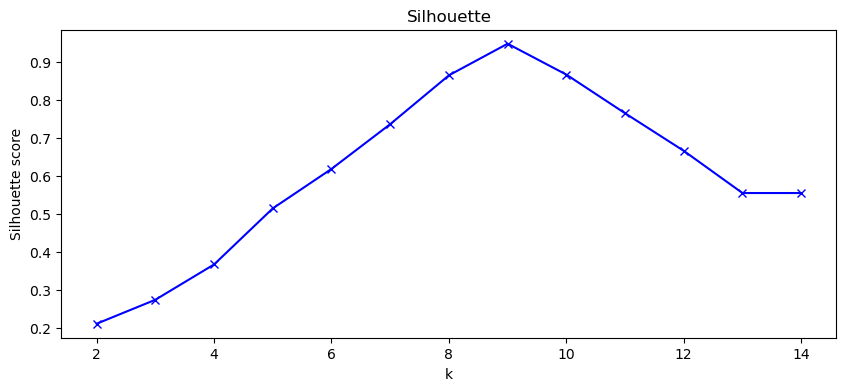

In [9]:
distortions = []
silhouette = []
K = range(1, 15)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_pca)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(X_pca, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

Both the silhouette and elbow method suggest the same number of clusters - 9.

In [11]:
kmeanModel = KMeans(n_clusters=9)
kmeanModel.fit(X_pca)

KMeans(n_clusters=9)

In [13]:
emb_df['label'] = kmeanModel.labels_

Judging by such clustering, only for the application should have a cosine distance, which is significantly less than the distance relative to others.

In [14]:
distances = np.zeros((len(X), len(X)))

for i in range(len(X)):
    for j in range(len(X)):
        distances[i, j] = cosine(emb_df['embedding'].iloc[i], emb_df['embedding'].iloc[j])

In [15]:
temp = pd.DataFrame(distances, columns=[emb_df.bundleId.values], index=[emb_df.bundleId.values])

In [16]:
temp = temp.applymap(lambda x: np.round(x,3))

In [17]:
np.fill_diagonal(temp.values, np.nan)

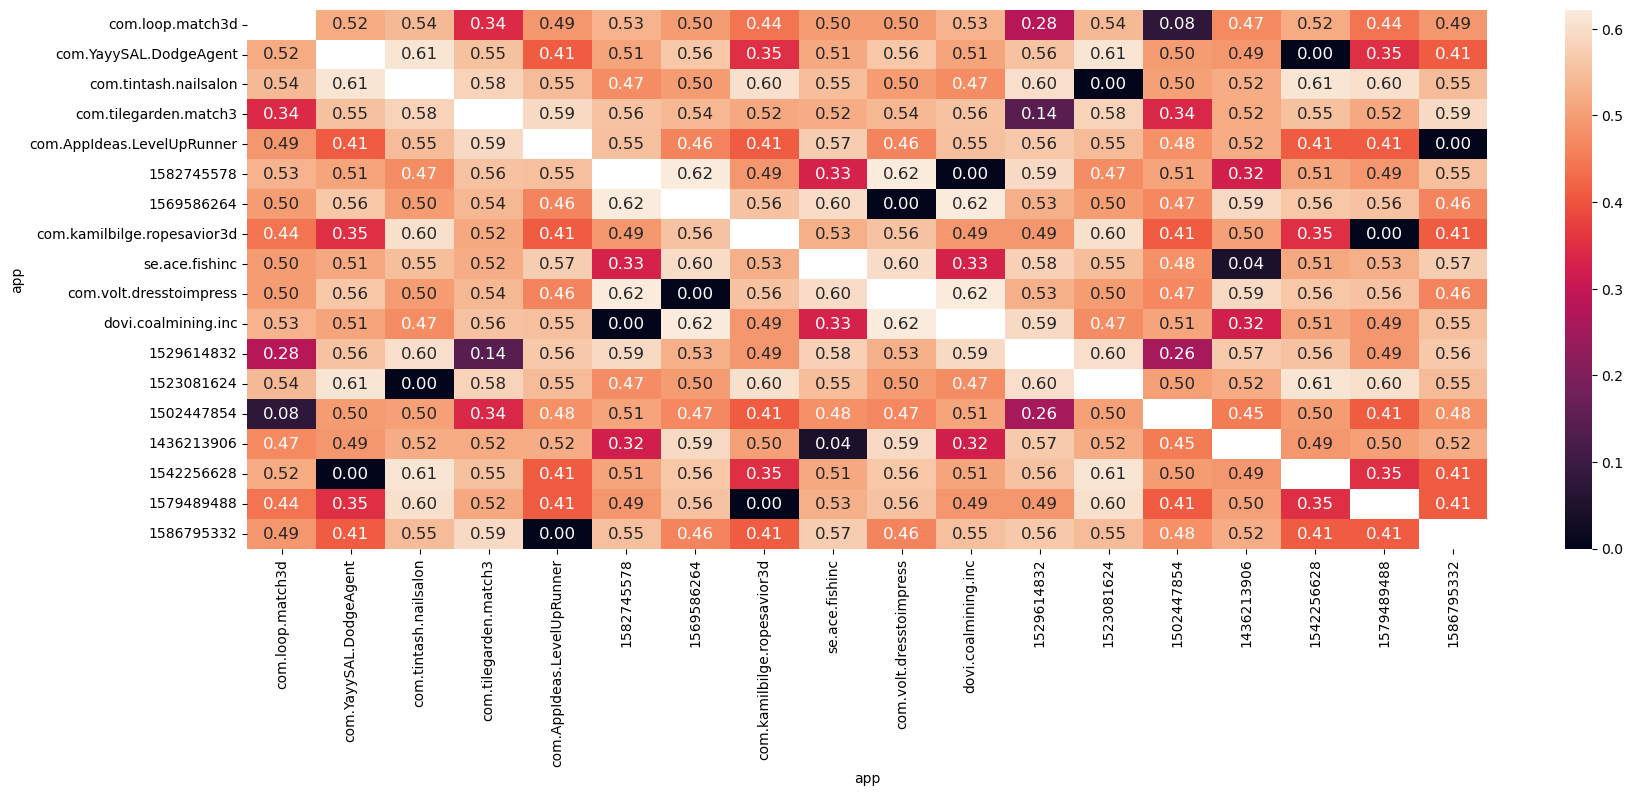

In [18]:
plt.figure(figsize=(20,7))
sns.heatmap(temp, annot=True, fmt=".2f", annot_kws={"size": 12})
plt.xlabel('app')
plt.ylabel('app');

Judging by this graph, there are only a couple of applications whose descriptions are close to each other, the rest are at approximately the same distance, with rare exceptions and it makes sense to consider how the price is distributed for similar applications.

In [19]:
array_cols = np.array([item[0] for item in temp.columns])

In [20]:
new_table = pd.DataFrame(columns=['app', 'max_dist', 'max_dist_app', 'min_dist', 'min_dist_app'])

In [21]:
new_table['app'] = array_cols
new_table['max_dist_app'] = array_cols[np.nanargmax(temp.to_numpy(), axis=1)]
new_table['min_dist_app'] = array_cols[np.nanargmin(temp.to_numpy(), axis=1)]
new_table['max_dist'] = temp.to_numpy()[np.arange(temp.to_numpy().shape[0]), np.nanargmax(temp.to_numpy(), axis=1)]
new_table['min_dist'] = temp.to_numpy()[np.arange(temp.to_numpy().shape[0]), np.nanargmin(temp.to_numpy(), axis=1)]

In [22]:
new_table = new_table.merge(
    emb_df[['bundleId', 'label']].rename(columns={'bundleId' : 'app'}), 
    how='left', 
    on='app').sort_values(by='label')

In [23]:
new_table

,app,max_dist,max_dist_app,min_dist,min_dist_app,label
1,com.YayySAL.DodgeAgent,0.611,com.tintash.nailsalon,0.000,1542256628,0
15,1542256628,0.611,com.tintash.nailsalon,0.000,com.YayySAL.DodgeAgent,0
5,1582745578,0.622,1569586264,0.000,dovi.coalmining.inc,1
10,dovi.coalmining.inc,0.622,1569586264,0.000,1582745578,1
6,1569586264,0.622,1582745578,0.000,com.volt.dresstoimpress,2
9,com.volt.dresstoimpress,0.622,1582745578,0.000,1569586264,2
3,com.tilegarden.match3,0.592,com.AppIdeas.LevelUpRunner,0.142,1529614832,3
11,1529614832,0.602,com.tintash.nailsalon,0.142,com.tilegarden.match3,3
2,com.tintash.nailsalon,0.611,com.YayySAL.DodgeAgent,0.000,1523081624,4
12,1523081624,0.611,com.YayySAL.DodgeAgent,0.000,com.tintash.nailsalon,4


From the table, it can be seen that the clustering worked well and matches the minimum distance.

Now let's see what the price distributions look like for an application from one cluster.

In [24]:
all_df = all_df.merge(emb_df[['bundleId', 'label']], how='left', on='bundleId')

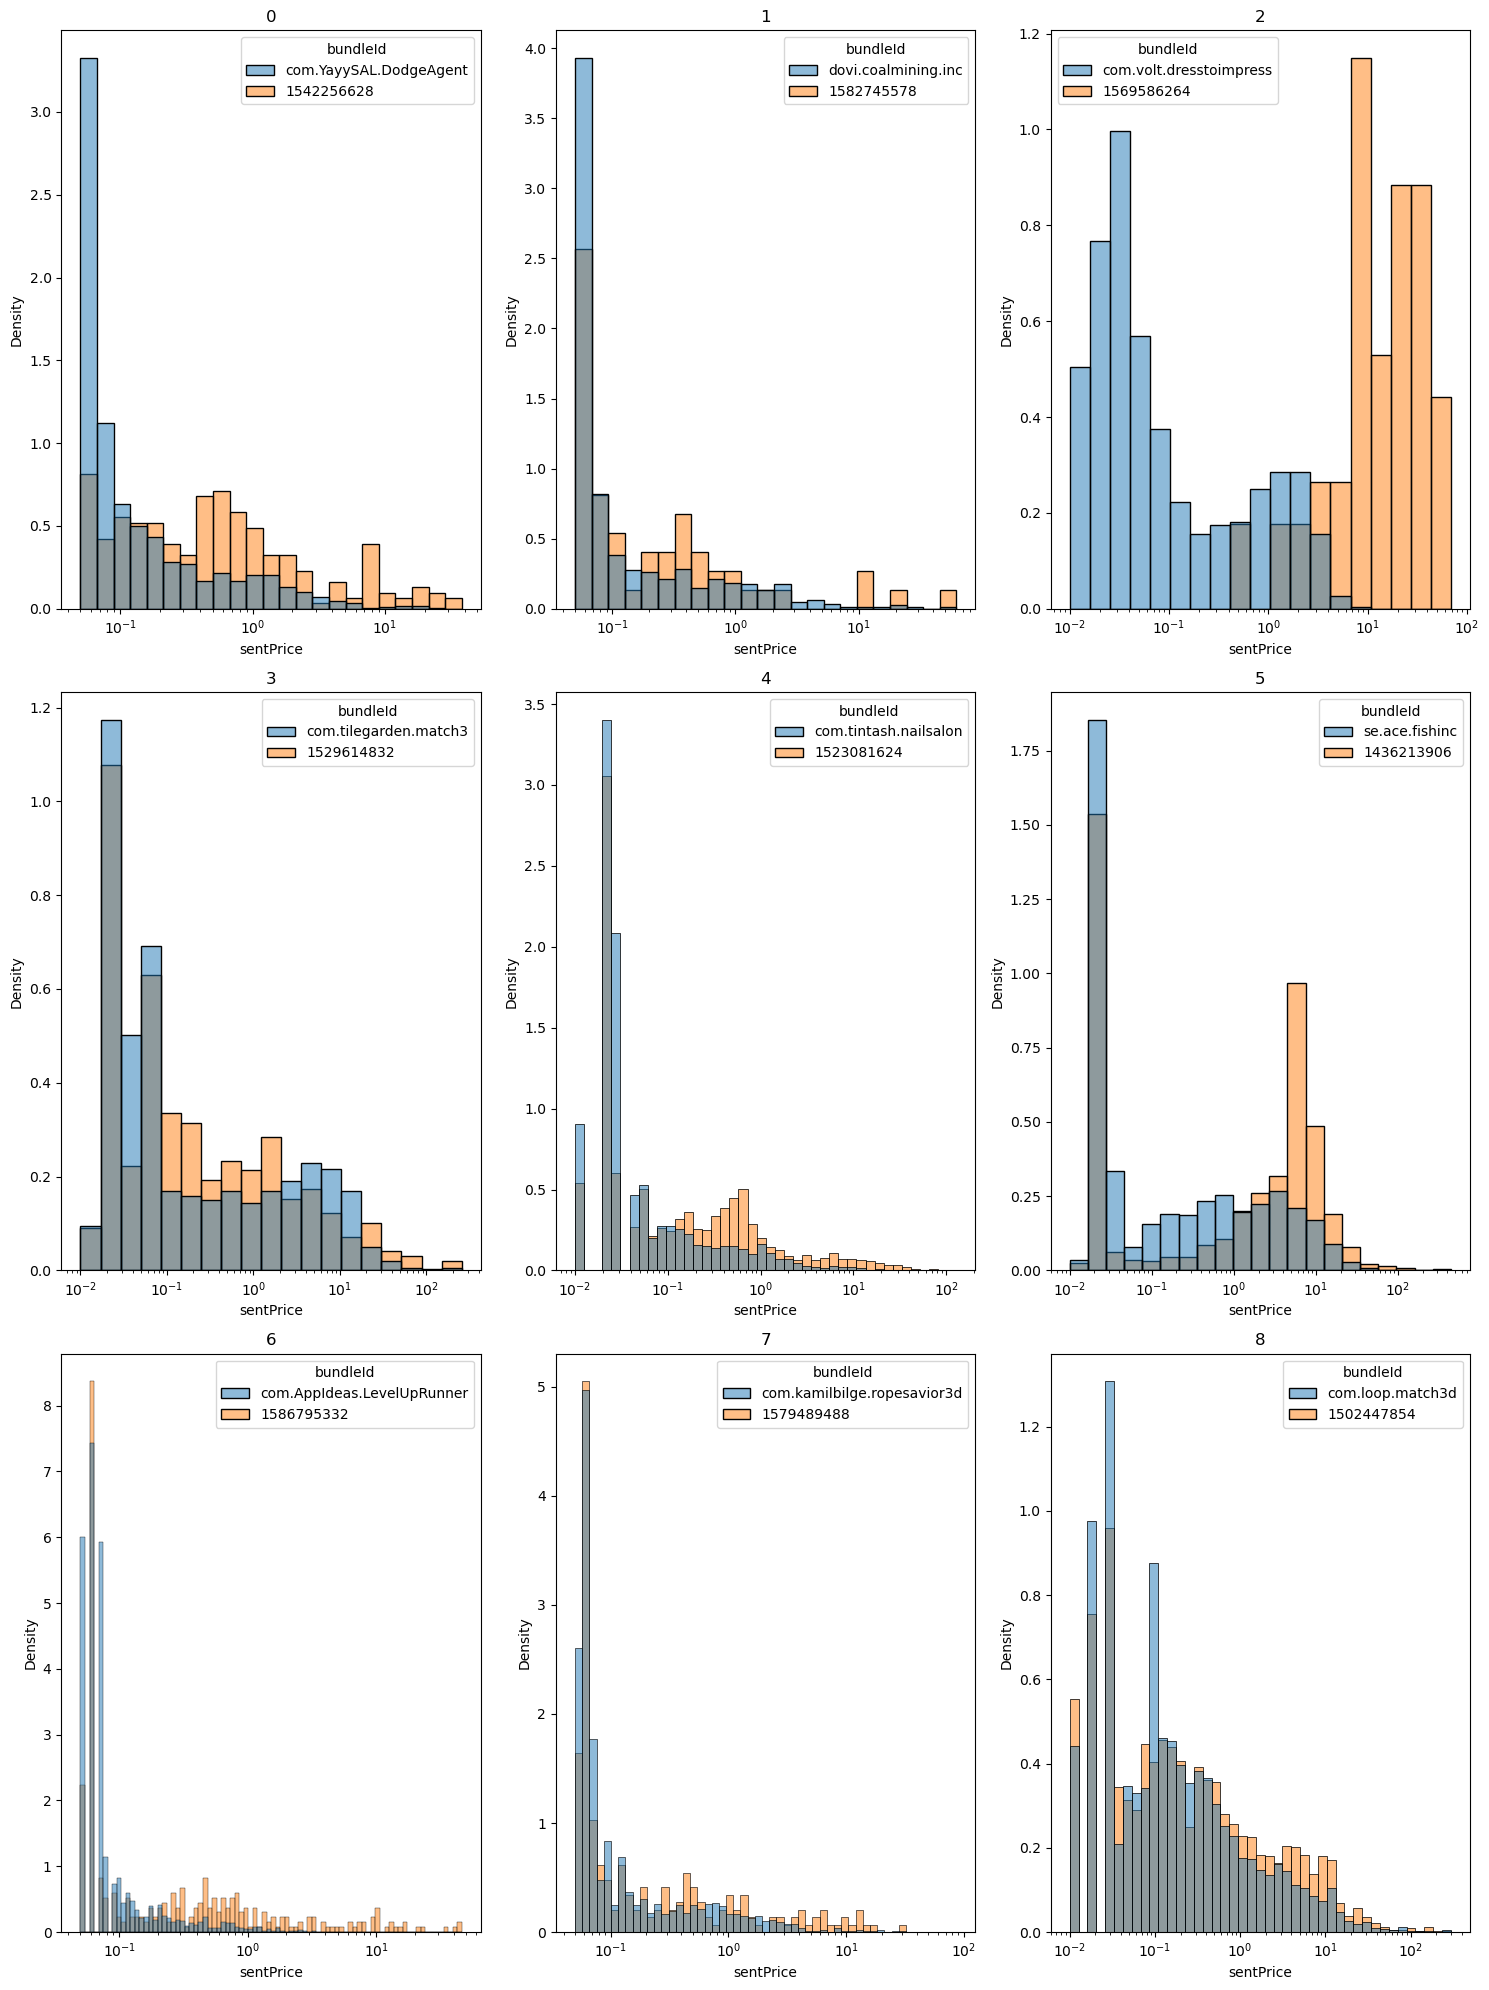

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(15, 20))  # создаем 15 субплотов: 5 строк по 3 столбца
axs = axs.ravel()  # преобразуем 2D массив в 1D для удобства
label = sorted(all_df.label.unique())
for i in range(all_df.label.nunique()):   # для каждого набора данных
    label_temp = label[i]
    sns.histplot(
        data=all_df.loc[all_df.label.eq(label_temp), ['sentPrice', 'bundleId']], 
        x ='sentPrice', ax=axs[i], hue='bundleId', log_scale=True, common_norm=False, stat='density')  # строим kde plot
    axs[i].set_title(f'{label_temp}')
    
plt.tight_layout()  # автоматическое улучшение расположения субплотов
plt.show()  # показываем получившийся график

I have converted to a logarithmic scale for a more visual comparison of price distributions for items from different clusters. But even visual analysis shows that the distributions are not very similar.

Also, it can be seen that the distributions are not normal, they have heavy tails and standard ANOVA post hoc tests Tukey do not allow working with such distributions. Probably, to understand whether they differ from each other or not, we can use bootstrap, to calculate the difference of means. If the difference of means is significant, then we can say that the hypothesis about similar prices in similar applications does not justify itself.

In [26]:
# butsrap function
def self_bootstrap(arr, num_samples):
    return np.random.choice(arr, size=[len(arr), num_samples])

Now let's look at the price distribution depending on the OS within the application and in general.

In [27]:
all_df['OS'] = all_df.osAndVersion.apply(lambda x: x.split('-')[0])

''

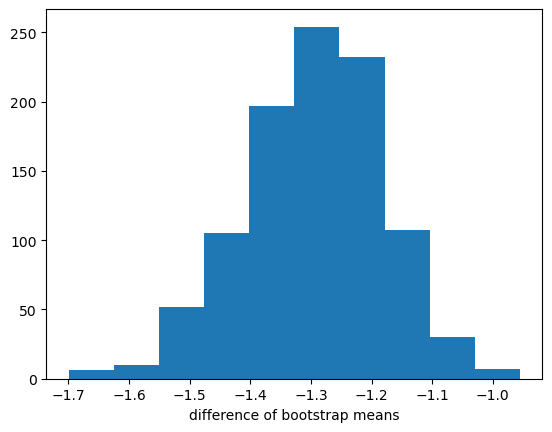

In [28]:
plt.hist(np.mean(self_bootstrap(arr = all_df.loc[all_df.OS.eq('Android'), 'sentPrice'].values, num_samples=1000),axis=0) 
         - np.mean(self_bootstrap(arr = all_df.loc[all_df.OS.eq('iOS'), 'sentPrice'].values, num_samples=1000),axis=0), bins = 10)
plt.xlabel('difference of bootstrap means')
;

It can be seen that the bootstrap-calculated mean difference is less than 0 and at the significance level of 0.05 it can be said that the mean values are different.

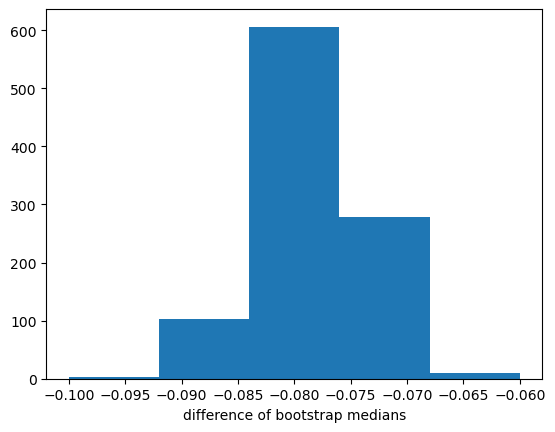

In [29]:
plt.hist(np.median(self_bootstrap(arr = all_df.loc[all_df.OS.eq('Android'), 'sentPrice'].values, num_samples=1000),axis=0) 
         - np.median(self_bootstrap(arr = all_df.loc[all_df.OS.eq('iOS'), 'sentPrice'].values, num_samples=1000),axis=0), bins = 5)
plt.xlabel('difference of bootstrap medians');

At the level of medians, a difference can also be seen, I decided to check the median due to the large number of outliers that can distort the mean value.

Let's do the same analysis at the application level, checking the hypothesis of whether the average price differs by systems within the application.





In [30]:
os_price_distr = all_df.groupby(['OS', 'bundleId']).apply(
    lambda df: pd.Series({'arr_sentPrice' : df.sentPrice.values, 'counter' : df.shape[0]}
                        )
).reset_index()

In [31]:
os_price_distr = os_price_distr.merge(emb_df[['bundleId', 'label']], how='left', on='bundleId')

Judging by this table, these applications are replicas of each other, but in different systems. This hypothesis will be confirmed if you just compare the descriptions and find them in the stores. If we have different prices in the systems, then even applications close to each other will have different distributions. We will attach labels to this table and look at the difference in average prices for each label, actually returning to the original task.

In [32]:
os_price_distr['bs_median_price'] = os_price_distr['arr_sentPrice'].apply(lambda x: np.median(self_bootstrap(arr=x, num_samples = 1000), axis=0))

In [33]:
os_price_distr = os_price_distr.explode('bs_median_price')

In [34]:
os_price_distr.columns

Index(['OS', 'bundleId', 'arr_sentPrice', 'counter', 'label',
       'bs_median_price'],
      dtype='object')

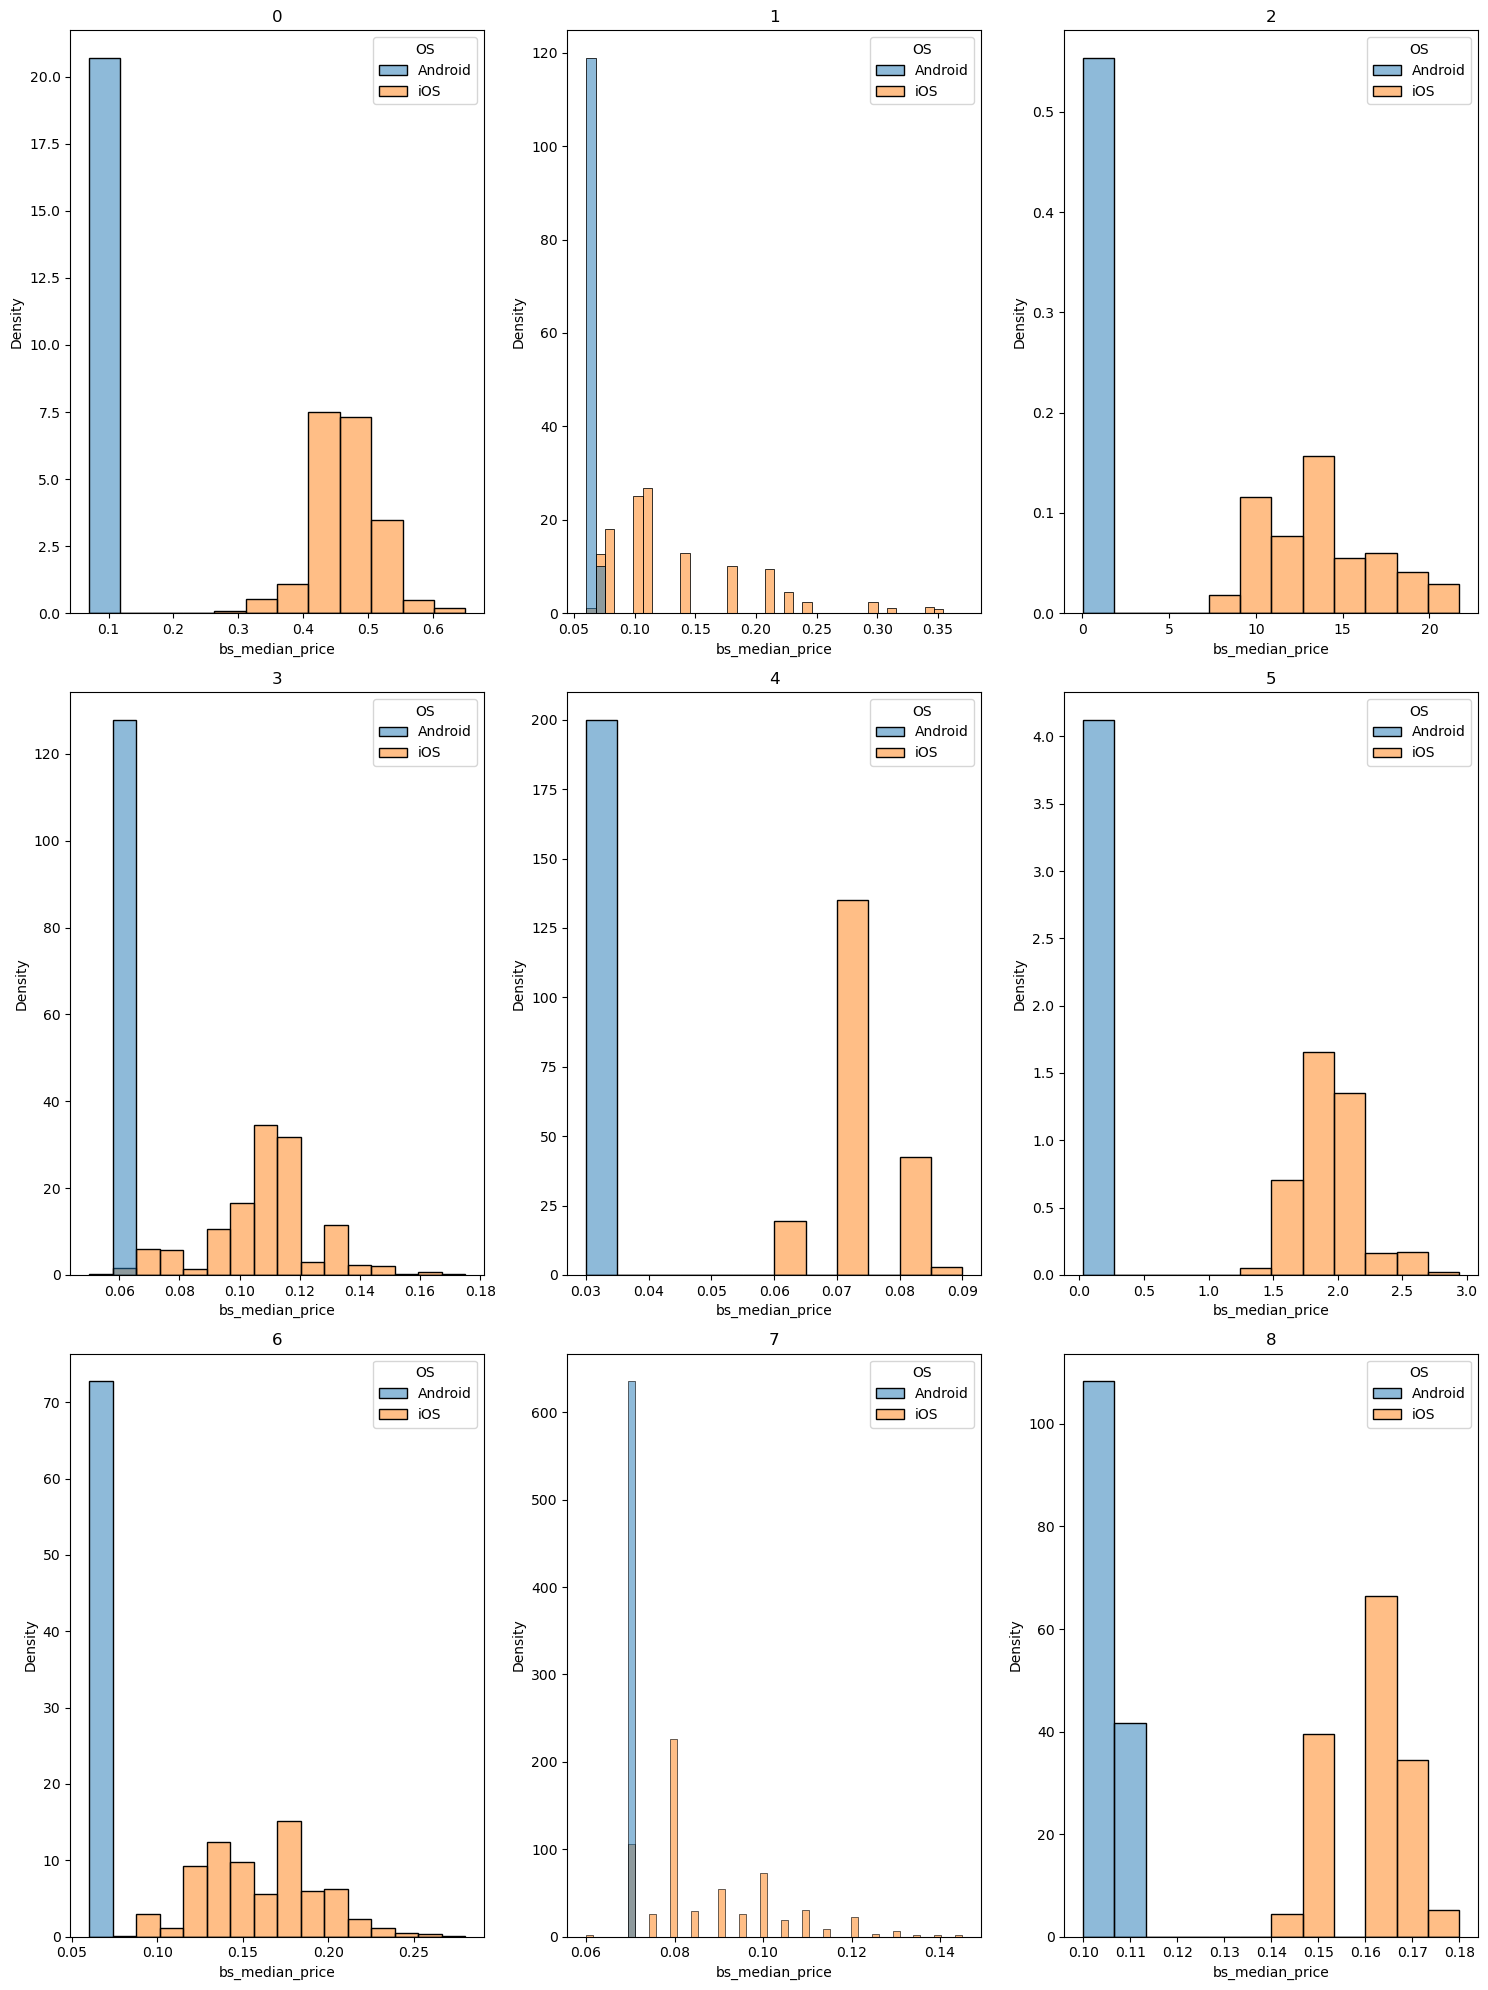

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(15, 20))  # создаем 15 субплотов: 5 строк по 3 столбца
axs = axs.ravel()  # преобразуем 2D массив в 1D для удобства
label = sorted(os_price_distr.label.unique())
for i in range(os_price_distr.label.nunique()):   # для каждого набора данных
    label_temp = label[i]
    sns.histplot(
        data=os_price_distr.loc[os_price_distr.label.eq(label_temp), ['bs_median_price', 'OS']], 
        x ='bs_median_price', ax=axs[i], hue='OS', log_scale=False, common_norm=False, stat='density')  # строим kde plot
    axs[i].set_title(f'{label_temp}')
    
plt.tight_layout()  # автоматическое улучшение расположения субплотов
plt.show()  # показываем получившийся график

Without applying any tests, it becomes clear that the median price depends on the operating system, for the Android system it is usually lower than for iOS.

As we found out above, the price can vary for different systems, now let's see if the price varies for countries. To do this, we will take only one system, for example, Android.

In [36]:
os_country_price_distr = all_df.groupby(['OS', 'bundleId', 'countryCode']).apply(
    lambda df: pd.Series({'arr_sentPrice' : df.sentPrice.values, 'counter' : df.shape[0]}
                        )
).reset_index()

In [37]:
os_country_price_distr = os_country_price_distr[os_country_price_distr.OS.eq('Android') & os_country_price_distr.counter.gt(50)]

In [38]:
os_country_price_distr['bs_median_price'] = os_country_price_distr['arr_sentPrice'].apply(
    lambda x: np.median(self_bootstrap(arr=x, num_samples = 1000), axis=0)
)

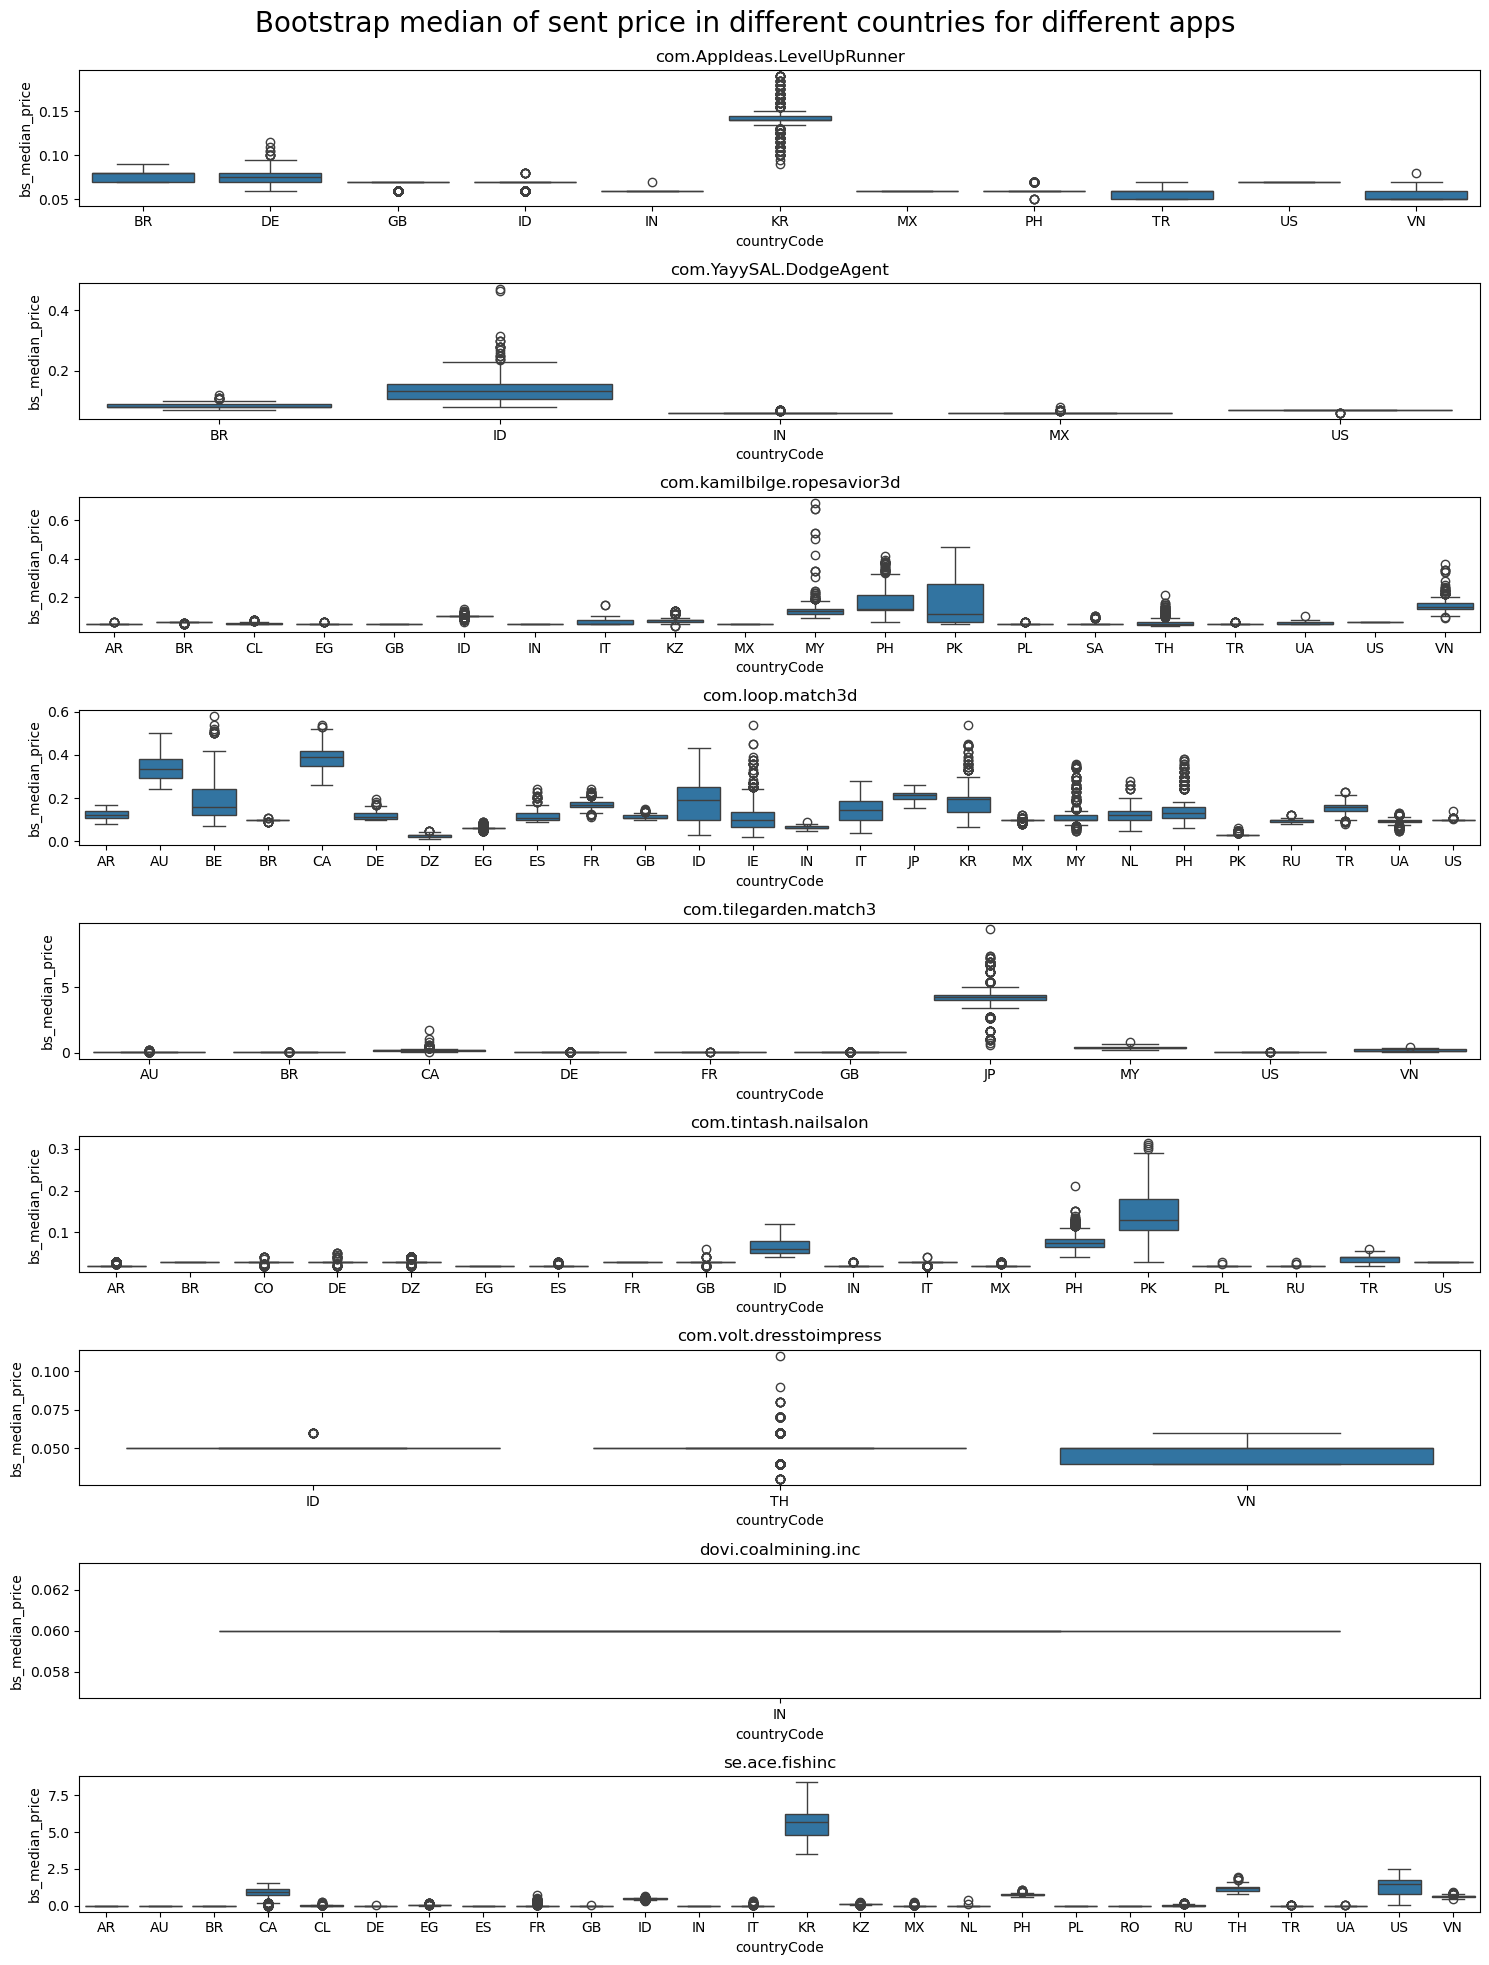

In [39]:
data_temp = os_country_price_distr.loc[os_country_price_distr.counter.gt(50), 
['bundleId', 'countryCode', 'bs_median_price']].explode('bs_median_price')
fig, axs = plt.subplots(data_temp.bundleId.nunique(), 1, figsize=(15, 20)) 
axs = axs.ravel()
label = data_temp.bundleId.unique()
for i in range(len(label)): 
    label_temp = label[i]
    sns.boxplot(
        data=data_temp.loc[data_temp.bundleId.eq(label_temp), ['bs_median_price', 'countryCode']], 
        x = 'countryCode',
        y ='bs_median_price' , ax=axs[i]) 
    # axs[i].set_yscale("log")
    axs[i].set_title(f'{label_temp}')
fig.suptitle(' Bootstrap median of sent price in different countries for different apps ', fontsize=20) 
plt.tight_layout() # автоматическое улучшение расположения субплотов
fig.subplots_adjust(top=0.95)
plt.show()  # показываем получившийся график

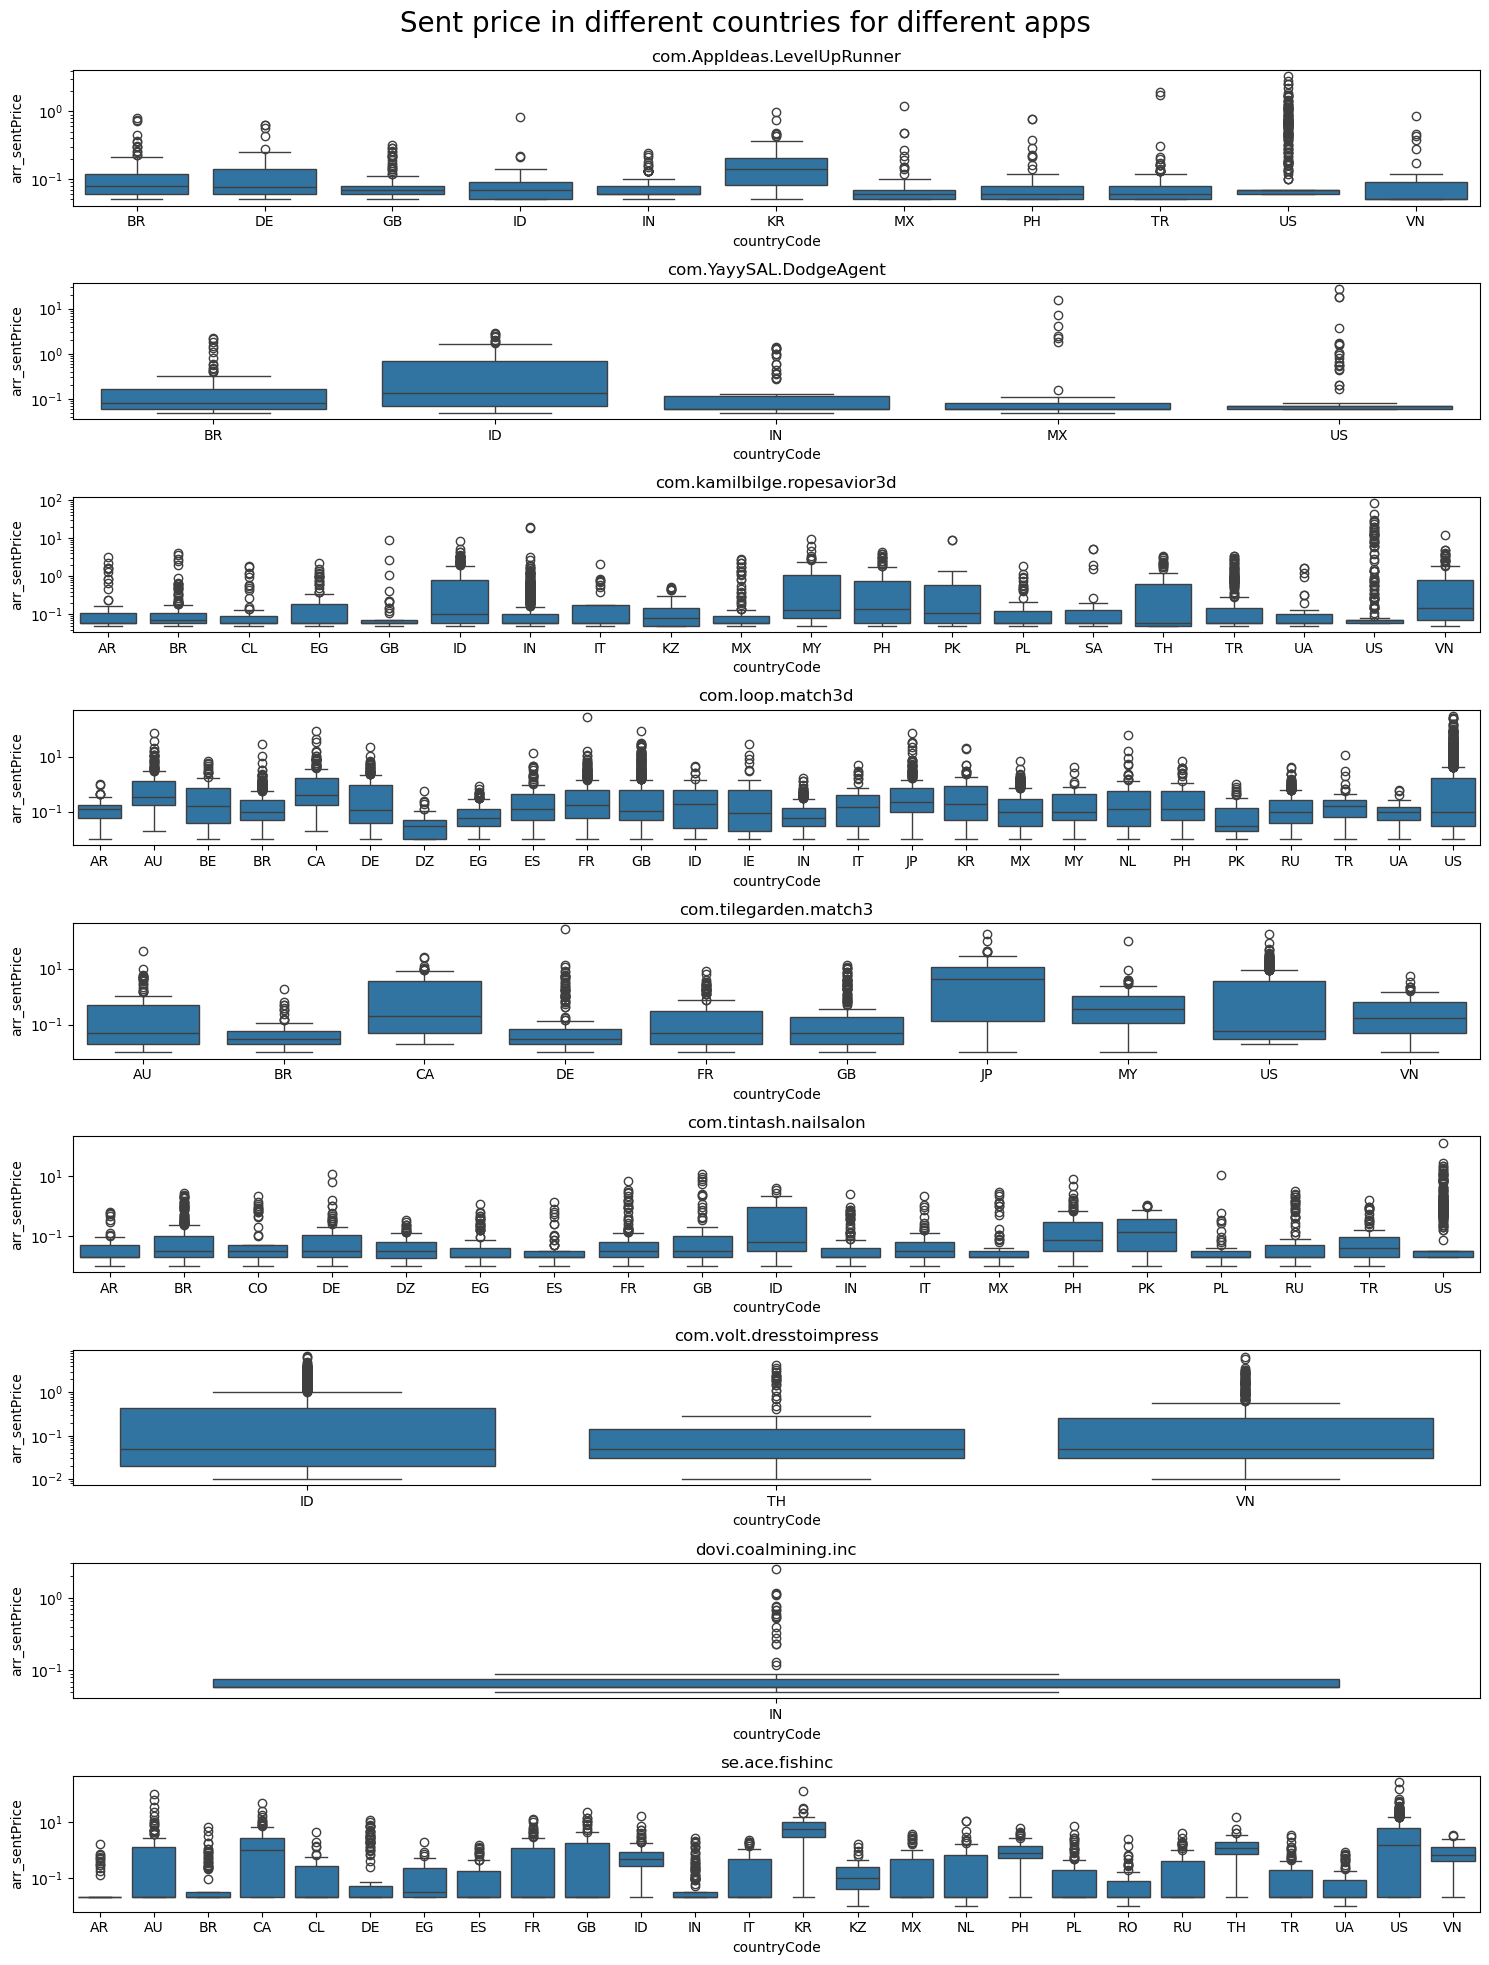

In [40]:
data_temp = os_country_price_distr.loc[os_country_price_distr.counter.gt(50), 
['bundleId', 'countryCode', 'arr_sentPrice']].explode('arr_sentPrice')
fig, axs = plt.subplots(len(label), 1, figsize=(15, 20)) 
axs = axs.ravel()
label = data_temp.bundleId.unique()
for i in range(len(label)): 
    label_temp = label[i]
    sns.boxplot(
        data=data_temp.loc[data_temp.bundleId.eq(label_temp), ['arr_sentPrice', 'countryCode']], 
        x = 'countryCode',
        y ='arr_sentPrice' , ax=axs[i]) 
    axs[i].set_yscale("log")
    axs[i].set_title(f'{label_temp}')
fig.suptitle(' Sent price in different countries for different apps ', fontsize=20) 
plt.tight_layout() # автоматическое улучшение расположения субплотов
fig.subplots_adjust(top=0.95)
plt.show()  # показываем получившийся график

Visually, it is easy to determine in which countries the median price varies within one application. For example, for the LevelUpRunner and fishink applications, it is clear that the highest median price is in Korea, for the match3 application in Japan. 

For a more quantitative determination of whether there is a difference in prices, we will apply the Kruskal statistical criterion (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html). This is a non-parametric analogue of the ANOVA criterion. The null hypothesis states that there is no difference between the median price for different countries. The alternative is that there is. 

After this test, it is necessary to check between which countries there is this difference, for this we will use the Conover post hoc test (https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_conover.html), for pairwise checking differences in medians, to avoid the error that occurs when comparing hypotheses multiple times, we use Holm's correction.

In [41]:
s = os_country_price_distr.loc[
os_country_price_distr.counter.gt(50)].groupby('bundleId')['countryCode'].apply(lambda x: x.nunique())
condition = s > 1
apps = s[condition].index.to_list()

In [43]:
kruskal_df = pd.DataFrame(columns=['bundleId', 'p_val'])
ind = 0
for app in apps:
    samples = os_country_price_distr.loc[os_country_price_distr.counter.gt(50) & os_country_price_distr.bundleId.eq(app), 
    ['arr_sentPrice']]
    num_country = os_country_price_distr.loc[
    os_country_price_distr.counter.gt(50) &\
    os_country_price_distr.bundleId.eq(app), 'countryCode'].nunique()
    if num_country > 1:
        func = np.vectorize(lambda x : x.tolist(), otypes=[object])
        samples = func(samples.arr_sentPrice.values).tolist()
        _, p_val = kruskal(*samples, axis=0)
        ind += 1
        kruskal_df = pd.concat([kruskal_df, pd.DataFrame({'bundleId': [app], 'p_val': [p_val]})], ignore_index=True)
    else: 
        continue

In [44]:
kruskal_df

,bundleId,p_val
0,com.AppIdeas.LevelUpRunner,3.960857e-37
1,com.YayySAL.DodgeAgent,3.146210e-09
2,com.kamilbilge.ropesavior3d,1.276575e-40
3,com.loop.match3d,2.704670e-114
4,com.tilegarden.match3,2.684844e-36
5,com.tintash.nailsalon,1.204306e-40
6,com.volt.dresstoimpress,9.097710e-01
7,se.ace.fishinc,1.195559e-153


In all applications except com.volt.dresstoimpress and dovi.coalmining.inc, the medians differ in at least one pair of countries, now let's find these countries.

In [59]:
def posthoct_conover_graph(application, data=os_country_price_distr, num_count=50):
    samples = data.loc[
    data.counter.gt(num_count) & data.bundleId.eq(application), ['arr_sentPrice']]
    values_country =  data.loc[
    data.counter.gt(num_count) & data.bundleId.eq(application), 'countryCode'].unique()
    func = np.vectorize(lambda x : x.tolist(), otypes=[object])
    samples = func(samples.arr_sentPrice.values).tolist()
    data_p_val = sp.posthoc_conover(samples, p_adjust = 'holm').applymap(lambda x: np.round(x, 3))
    plt.figure(figsize=(20,7))
    sns.heatmap(pd.DataFrame(data_p_val.to_numpy(), columns=values_country, index=values_country), annot=True)

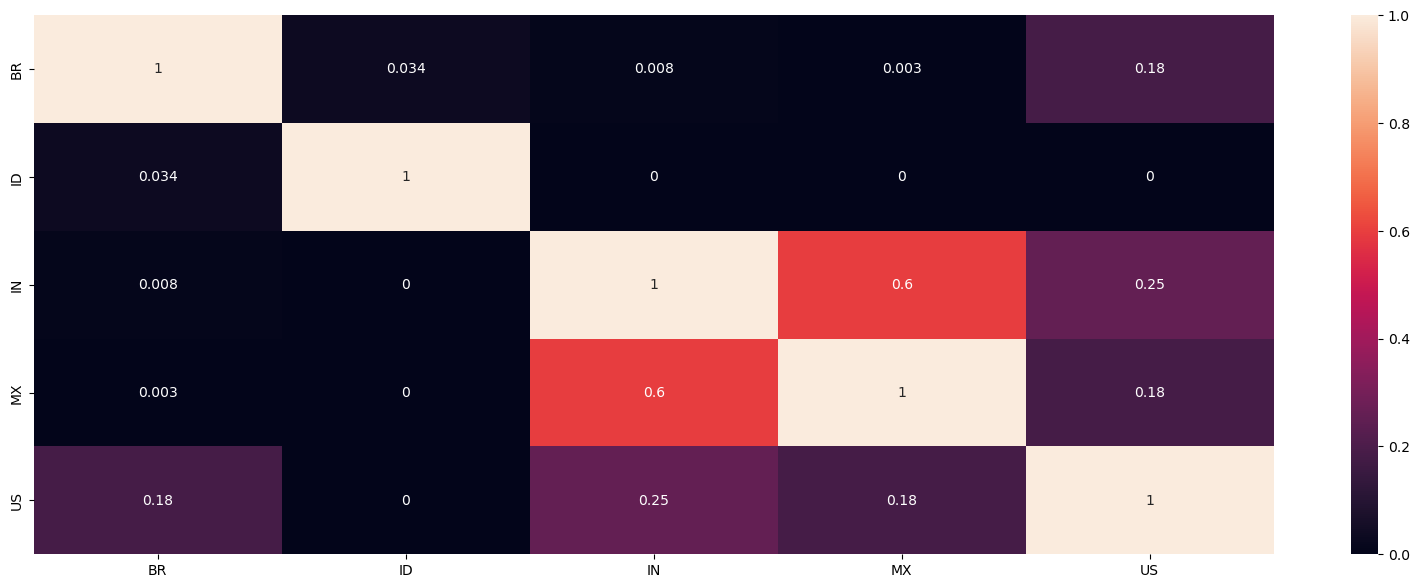

In [61]:
posthoct_conover_graph(application='com.YayySAL.DodgeAgent')

# Conclusions:
Upon running the clustering algorithm on our applications, we observe that the applications are divided into 9 clusters, each containing two applications. The dimensions of the embedding can be reduced to 6 coordinates, while still retaining 95% of the variance, which subsequently also forms 9 clusters in this reduced space.

From the table illustrating the cosine distance between pairs of applications, it is evident that the distance within the same cluster is significantly smaller than the distances between different clusters. We therefore refine our initial hypothesis regarding price dependency on cosine distance, to postulate that the price distribution of closest applications should ideally be identical. Visual analysis, however, disproves this notion.

Because the frequency distributions have heavy tails, I decided to test this hypothesis by applying the bootstrapping method on the sample and comparing the median values of the bootstrapped samples. Visual analysis showed variations in distributions across different applications.

Upon further analysis, it was discerned that the applications responsible for forming these clusters belonged to distinct systems, Android and iOS.

Comparing the aggregate prices in the Android and iOS systems using the bootstrap method revealed that iOS applications typically have a higher median price.

Price comparison of iOS and Android applications within each cluster (both an Android and its equivalent iOS application are always present in the same cluster) using the bootstrap method showed a statistically significant difference. It implies that applications with similar cosine distances have different price distributions.

The subsequent step was to examine if the price varied by country. For this, I analyzed the distribution of prices by country for applications in the Android system, excluding countries having less than 50 price offers.  To test the hypothesis that there exists at least one group of countries within the data set with differing median prices, I adopted the Kruskal statistical criterion. However, the results showed no difference in the applications com.volt.dresstoimpress. For dovi.coalmining.inc, substantial data was not available.

I performed a pairwise test of the difference in median using the Conover post-hoc test. The test provided distinctive price distribution scenarios.
